## Neural Network

Alexandros Christou 0556437

Here I implemented A recurrent neural network. I used a recurrent neural network because we have some kind of time series data and I think that a RNN could be more precisely at prediting the appliances. However, I did not ahd time to fully train this model and is therefore unfinished. But I would like to submit this as an extra because there was quiet some effort thrown into it. 

In [22]:
import scipy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

'''Plotly visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook



In [2]:
data_folder = "./"
train_data = pd.read_csv(data_folder + "train.csv", parse_dates = ['date'], index_col='date')
data = pd.read_csv(data_folder + "train.csv")
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d %H:%M:%S')
test_data = pd.read_csv(data_folder + "test.csv", parse_dates = ['date'], index_col='date')
duplicate_train = data.copy()
test_data_copy = pd.read_csv(data_folder + "test.csv")

In [3]:
#gets all the hours of a day that occurs in the dataframes
def get_hours():
    hours = []
    dates = data.date
    idx = 0
    for i, date in enumerate(dates):
        if not (np.isin(date.time(), hours)):
            hours.append(date.time())
            idx = idx + 1
    return hours

hours = np.array(get_hours())

In [4]:
def Average(lst):
    return sum(lst) / len(lst)

def get_mean(hour, variable, dataset):
    
    res = [] 
    for i, x in enumerate(data.date): 
        if(x.time() == hour):
            
            res.append(dataset[variable][i])
    return Average(res)

def add_mean(hours, variable, dataset):
    means = {} 
    for hour in hours:
        mean = get_mean(hour, variable, dataset)
        means[hour] = mean
    return means

def get_meansArray(variable, hours, dataset, size):
    means = add_mean(hours, variable, dataset)
    meansArray = np.zeros(size)
    for i, date in enumerate(data.date):
        meansArray[i] = means[date.time()]
    return meansArray

def calculateAverage(column, dataset, size):
    means = get_meansArray(column, hours, dataset, size)
    df = pd.DataFrame(data=means, columns=[f'mean{column}'])
    return df

In [5]:
MeanAppliances = calculateAverage('Appliances', train_data, len(train_data))
print(train_data.shape)
train_data['MeanAppliances'] = MeanAppliances.iloc[:,0].values
train_data.MeanAppliances.head()

(15000, 28)


date
2016-01-11 17:00:00    123.047619
2016-01-11 17:10:00    121.333333
2016-01-11 17:20:00    138.380952
2016-01-11 17:30:00    166.476190
2016-01-11 17:40:00    178.285714
Name: MeanAppliances, dtype: float64

In [6]:
# assign your new columns
datetimes = data['date']

train_data['year'] = datetimes.dt.year.values
train_data['month'] = datetimes.dt.month.values
train_data['day'] = datetimes.dt.day.values
train_data['hour'] = datetimes.dt.hour.values
train_data['day_of_week'] = datetimes.dt.dayofweek.values
train_data['is_weekend'] = np.where(train_data['day_of_week'].isin([5, 6]), 1.0,0.0)

#df['is_peak'] = np.where(df['hour'].isin([8,9,12,19,22]), 1,0)
train_data['minute'] = datetimes.dt.minute.values
#train_data = train_data.drop(['date'], axis=1)
print(train_data['is_weekend'] )
pass

date
2016-01-11 17:00:00    0.0
2016-01-11 17:10:00    0.0
2016-01-11 17:20:00    0.0
2016-01-11 17:30:00    0.0
2016-01-11 17:40:00    0.0
                      ... 
2016-04-24 20:10:00    1.0
2016-04-24 20:20:00    1.0
2016-04-24 20:30:00    1.0
2016-04-24 20:40:00    1.0
2016-04-24 20:50:00    1.0
Name: is_weekend, Length: 15000, dtype: float64


In [7]:
clean_data = train_data.copy()
clean_data.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,rv2,Appliances,MeanAppliances,year,month,day,hour,day_of_week,is_weekend,minute
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,13.275433,60,123.047619,2016,1,11,17,0,0.0,0
2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,18.606195,60,121.333333,2016,1,11,17,0,0.0,10
2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,28.642668,50,138.380952,2016,1,11,17,0,0.0,20
2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.410389,50,166.476190,2016,1,11,17,0,0.0,30
2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,10.084097,60,178.285714,2016,1,11,17,0,0.0,40


In [9]:
clean_data.shape


(15000, 36)

In [10]:
clean_copy = clean_data.copy()
clean_copy = clean_copy.drop(['Appliances'], axis = 1)

In [11]:
from pandas import read_csv
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot
# load dataset
T = clean_data.Appliances
# perform feature selection
rfe = RFE(RandomForestRegressor(), n_features_to_select=10)
fit = rfe.fit(clean_copy, T)
# report selected features
names = clean_copy.columns.values
columns = []
print('Selected Features:')
for i in range(len(fit.support_)):
    if fit.support_[i]:
        columns.append(names[i])
print(columns)

Selected Features:
['T2', 'RH_2', 'T3', 'RH_3', 'RH_5', 'T6', 'RH_8', 'Press_mm_hg', 'Tdewpoint', 'MeanAppliances']


In [12]:
#Credit: Adopted from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #print(names)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
# Feature engineering for LSTM
columns = ['RH_2', 'T3', 'T_out', 'Press_mm_hg', 'MeanAppliances']
columns.append('day')
columns.append('hour')
columns.append('Appliances')
scaled_train = clean_data[columns]
scalers={}
for i in columns:#clean_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(scaled_train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    scaled_train[i]=s_s
print(scalers)
#print(clean_data.columns)
reframed_data = series_to_supervised(scaled_train, 5, 1)
reframed_data.head()

{'scaler_RH_2': MinMaxScaler(feature_range=(-1, 1)), 'scaler_T3': MinMaxScaler(feature_range=(-1, 1)), 'scaler_T_out': MinMaxScaler(feature_range=(-1, 1)), 'scaler_Press_mm_hg': MinMaxScaler(feature_range=(-1, 1)), 'scaler_MeanAppliances': MinMaxScaler(feature_range=(-1, 1)), 'scaler_day': MinMaxScaler(feature_range=(-1, 1)), 'scaler_hour': MinMaxScaler(feature_range=(-1, 1)), 'scaler_Appliances': MinMaxScaler(feature_range=(-1, 1))}


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var1(t-4),var2(t-4),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:50:00,0.257407,-0.501923,-0.060729,-0.804651,-0.218977,-0.333333,0.478261,-0.906542,0.252946,-0.501923,...,0.478261,-0.906542,0.238242,-0.501923,-0.107962,-0.781395,0.278035,-0.333333,0.478261,-0.925234
2016-01-11 18:00:00,0.252946,-0.501923,-0.070175,-0.800000,-0.236281,-0.333333,0.478261,-0.906542,0.246613,-0.501923,...,0.478261,-0.925234,0.238242,-0.501923,-0.117409,-0.776744,0.065579,-0.333333,0.565217,-0.906542
2016-01-11 18:10:00,0.246613,-0.501923,-0.079622,-0.795349,-0.064202,-0.333333,0.478261,-0.925234,0.244190,-0.501923,...,0.565217,-0.906542,0.238242,-0.513462,-0.116059,-0.773643,0.090574,-0.333333,0.565217,-0.906542
2016-01-11 18:20:00,0.244190,-0.501923,-0.089069,-0.790698,0.219393,-0.333333,0.478261,-0.925234,0.240225,-0.501923,...,0.565217,-0.906542,0.233836,-0.513462,-0.114710,-0.770543,0.596238,-0.333333,0.565217,-0.906542
2016-01-11 18:30:00,0.240225,-0.501923,-0.098516,-0.786047,0.338599,-0.333333,0.478261,-0.906542,0.238242,-0.501923,...,0.565217,-0.906542,0.231633,-0.501923,-0.113360,-0.767442,0.856761,-0.333333,0.565217,-0.887850


In [14]:
# clean_train_data
print(reframed_data.shape)
for column in reframed_data:
    if "var8(t)" in column:
        targets =  reframed_data[column]
    if "var8" in column:
        print(column)
        reframed_data = reframed_data.drop(column, axis=1)

(14995, 48)
var8(t-5)
var8(t-4)
var8(t-3)
var8(t-2)
var8(t-1)
var8(t)


In [15]:
import math
from sklearn.preprocessing import StandardScaler

features = reframed_data.columns

target_values = targets.values

# split into train and test sets
values = reframed_data.values

train_index = round(len(values)*0.75)
train = values[:train_index, :]
test = values[train_index:, :]

train_X  = train #, targets#train[:, -1]
train_y = target_values[:train_index]

test_X = test #, test[:, -1]
test_y = target_values[train_index:]
# split into input and outputs


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].


(11246, 1, 42) (11246,) (3749, 1, 42) (3749,)


In [16]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation="LeakyReLU", input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss=root_mean_squared_error, optimizer='adam')
# fit network
history = model.fit(train_X, train_y,validation_data=(test_X, test_y), epochs=20, batch_size=40, verbose=1, shuffle=False) 

Epoch 1/20
282/282 [==============================] - 11s 12ms/step - loss: 0.2726 - val_loss: 0.1831
Epoch 2/20
282/282 [==============================] - 3s 10ms/step - loss: 0.1623 - val_loss: 0.1507
Epoch 3/20
282/282 [==============================] - 3s 10ms/step - loss: 0.1493 - val_loss: 0.1373
Epoch 4/20
282/282 [==============================] - 3s 10ms/step - loss: 0.1461 - val_loss: 0.1345
Epoch 5/20
282/282 [==============================] - 3s 10ms/step - loss: 0.1448 - val_loss: 0.1332
Epoch 6/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1442 - val_loss: 0.1318
Epoch 7/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1439 - val_loss: 0.1347
Epoch 8/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1435 - val_loss: 0.1373
Epoch 9/20
282/282 [==============================] - 3s 9ms/step - loss: 0.1433 - val_loss: 0.1409
Epoch 10/20
282/282 [==============================] - 3s 10ms/step - loss: 0.1428 - val_loss:

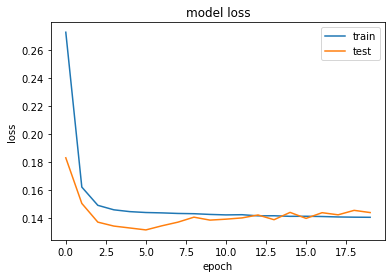

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error


yhat = model.predict(test_X, verbose=0)
test_y = test_y
scaler = scalers["scaler_Appliances"]

yhat = scaler.inverse_transform(yhat)
test_y = scaler.inverse_transform(test_y.reshape(-1,1))
print(yhat)
print(test_y)
rmse = np.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

[[ 99.77798 ]
 [104.343994]
 [101.58519 ]
 ...
 [ 82.59397 ]
 [ 80.77314 ]
 [ 80.910835]]
[[140.]
 [130.]
 [130.]
 ...
 [110.]
 [110.]
 [100.]]
Test RMSE: 100.220


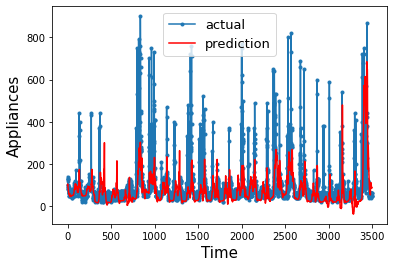

In [19]:
aa=[x for x in range(3500)]
plt.plot(aa, test_y[:3500], marker='.', label="actual")
plt.plot(aa, yhat[:3500], 'r', label="prediction")
plt.ylabel('Appliances', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()

In [20]:
# #gets all the hours of a day that occurs in the dataframes
# def get_hours():
#     hours = []
#     dates = train_data.date
#     idx = 0
#     for i, date in enumerate(dates):
#         if not (np.isin(date.time(), hours)):
#             hours.append(date.time())
#             idx = idx + 1
#     return hours

# hours = np.array(get_hours())

In [ ]:
# def Average(lst):
#     return sum(lst) / len(lst)

# def get_mean(hour, variable, dataset):
    
#     res = [] 
#     for i, x in enumerate(dataset.date): 
#         if(x.time() == hour):
#             res.append(dataset[variable][i])
#     return Average(res)

# def add_mean(hours, variable, dataset):
#     means = {} 
#     for hour in hours:
#         mean = get_mean(hour, variable, dataset)
#         means[hour] = mean
#     return means

# def get_meansArray(variable, hours, dataset, size):
#     means = add_mean(hours, variable, dataset)
#     meansArray = np.zeros(size)
#     for i, date in enumerate(dataset.date):
#         meansArray[i] = means[date.time()]
#     return meansArray

In [ ]:
# def calculateAverage(column, dataset, size):
#     means = get_meansArray(column, hours, dataset, size)
#     df = pd.DataFrame(data=means, columns=[f'mean{column}'])
#     return df

In [ ]:
# test_data_copy
# meansArray = np.zeros(4735)
# duplicate_train['date'] = pd.to_datetime(duplicate_train['date'], format = '%Y-%m-%d %H:%M:%S')
# test_data_copy['date'] = pd.to_datetime(test_data_copy['date'], format = '%Y-%m-%d %H:%M:%S')
# for i, date in enumerate(test_data_copy.date):
#     meansArray[i] = get_mean(date.time(), 'Appliances', duplicate_train)

# test_data['MeanAppliances'] = meansArray

In [ ]:
# # Feature engineering for LSTM
# datetimes = test_data_copy['date']
# test_data['day'] = datetimes.dt.day.values
# test_data['hour'] = datetimes.dt.hour.values
# columns_test = ['RH_2', 'T3', 'T_out', 'Press_mm_hg','day','hour', 'MeanAppliances',  ]
# scaled_test = test_data[columns_test]
# for i in columns_test:
#     scaler = scalers['scaler_'+i]
#     s_s = scaler.transform(scaled_test[i].values.reshape(-1,1))
#     s_s=np.reshape(s_s,len(s_s))
#     scalers['scaler_'+i] = scaler
#     scaled_test[i]=s_s



# reframed_data_supervised = series_to_supervised(scaled_test, 5, 1)
# reframed_data_supervised = np.array(reframed_data_supervised)
# print(scaled_test.shape)
# # reshape input to be 3D [samples, timesteps, features]
# reframed_data_reshaped = reframed_data_supervised.reshape((reframed_data_supervised.shape[0], 1, reframed_data_supervised.shape[1]))
# print(reframed_data_reshaped.shape)


In [ ]:
# model.summary()

In [ ]:
 
# yhat = model.predict(reframed_data_reshaped, verbose=0)

# scaler = scalers["scaler_Appliances"]

# yhat = scaler.inverse_transform(yhat)
# yhat = yhat.flatten()
# print(yhat)
# yhat = np.array(yhat)


In [ ]:
# first5 = yhat[0:5]
# predictions = np.insert(yhat, 0, first5, axis=0)


# predictions = np.full(test_data.shape[0], predictions)




In [ ]:
# import sys
# import os 
# import glob
# import time
# from scipy import stats
# def generate_unique_filename(basename, file_ext):
#     """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
#     timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
#     return basename + '_' + timestamp + '.' + file_ext

# submission = pd.DataFrame(data=predictions, columns=["Appliances"])
# submission.index.name = "Id"
# submission.head()

# submission.to_csv(generate_unique_filename("average_submission", "csv"))